# Phân Tích Chi Tiết Các Mô Hình Dự Đoán COCOMO II

Notebook này thực hiện phân tích chi tiết 3 mô hình dự đoán đã được huấn luyện cho dữ liệu COCOMO II bao gồm:
1. Linear Regression (Hồi quy tuyến tính)
2. Decision Tree Regressor (Cây quyết định hồi quy)
3. Random Forest Regressor (Rừng ngẫu nhiên hồi quy)

Dữ liệu được kết hợp từ 3 schema khác nhau:
- LOC (Lines of Code): Dựa trên số dòng mã
- FP (Function Points): Dựa trên điểm chức năng
- UCP (Use Case Points): Dựa trên điểm use case

Mục tiêu là phân tích hiệu suất và đặc điểm của từng mô hình, hiểu rõ cách chúng hoạt động trên các loại dữ liệu khác nhau, và đưa ra nhận xét về ưu/nhược điểm của mỗi phương pháp.

## 1. Import Các Thư Viện Cần Thiết

Đầu tiên, chúng ta cần import các thư viện cần thiết cho phân tích và trực quan hóa dữ liệu, xây dựng và đánh giá mô hình.

In [1]:
# Import các thư viện xử lý dữ liệu
import numpy as np
import pandas as pd
import os
import joblib
import json

# Import các thư viện trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Import các thư viện ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import các mô hình
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

# Import các metrics đánh giá
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Cấu hình hiển thị đồ thị
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Bỏ qua cảnh báo
import warnings
warnings.filterwarnings('ignore')

## 2. Tải và Khám Phá Dữ Liệu

Chúng ta sẽ tải dữ liệu từ file combined_data.csv, file này chứa dữ liệu đã được kết hợp từ 3 schema khác nhau (LOC, FP, UCP). Sau đó, chúng ta sẽ tìm hiểu tổng quan về dữ liệu và phân tích các đặc trưng.

In [2]:
# Đường dẫn đến file dữ liệu kết hợp
data_path = './processed_data/combined_data.csv'

# Tải dữ liệu
df = pd.read_csv(data_path)

# Hiển thị thông tin cơ bản về dữ liệu
print(f"Kích thước dữ liệu: {df.shape[0]} dòng × {df.shape[1]} cột")
print("\nCác cột trong dữ liệu:")
print(df.columns.tolist())

# Hiển thị vài dòng đầu tiên
print("\nDữ liệu mẫu:")
df.head()

Kích thước dữ liệu: 1579 dòng × 18 cột

Các cột trong dữ liệu:
['source', 'kloc', 'effort_pm', 'time_months', 'developers', 'schema', 'size', 'fp', 'ucp', 'uaw', 'uucw', 'tcf', 'ecf', 'sector', 'language', 'methodology', 'applicationtype', 'project_no']

Dữ liệu mẫu:


,source,kloc,effort_pm,time_months,developers,schema,size,fp,ucp,uaw,uucw,tcf,ecf,sector,language,methodology,applicationtype,project_no
0,ant-1.7.csv,0.185,0.1,0.10,1,LOC,0.185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ant-1.7.csv,0.345,0.1,0.17,1,LOC,0.345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ant-1.7.csv,0.041,0.1,0.10,1,LOC,0.041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ant-1.7.csv,0.483,0.1,0.24,1,LOC,0.483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ant-1.7.csv,1.085,0.1,0.56,1,LOC,1.085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Kiểm tra các thông tin thống kê cơ bản
print("Thông tin thống kê mô tả:")
df.describe().T

Thông tin thống kê mô tả:


,count,mean,std,min,25%,50%,75%,max
kloc,1341.0,0.302145,0.330889,0.001,0.0450,0.154,0.4610,1.085
effort_pm,1579.0,4.208512,12.440728,0.020,0.1000,0.100,0.3000,105.200
time_months,1579.0,2.310526,12.013124,0.000,0.0200,0.100,0.2600,190.200
developers,1579.0,30.501583,94.403815,1.000,1.0000,1.000,1.0000,399.000
size,1579.0,50.468003,149.529472,0.001,0.0570,0.229,0.8085,1902.000
fp,96.0,356.260417,346.760110,16.000,149.2500,237.000,422.0000,1902.000
ucp,142.0,317.484507,99.055039,114.170,248.2225,305.410,381.8500,659.660
uaw,142.0,10.450704,4.970234,6.000,7.0000,8.000,17.7500,19.000
uucw,142.0,385.492958,88.169545,250.000,315.0000,355.000,478.7500,610.000
tcf,142.0,0.921944,0.113327,0.710,0.8500,0.940,1.0200,1.118


Số lượng giá trị thiếu trong mỗi cột:
kloc                238
fp                 1483
ucp                1437
uaw                1437
uucw               1437
tcf                1437
ecf                1437
sector             1453
language           1467
methodology        1535
applicationtype    1479
project_no         1437
dtype: int64

Phân bố dữ liệu theo schema:
schema
LOC    1341
UCP     142
FP       96
Name: count, dtype: int64


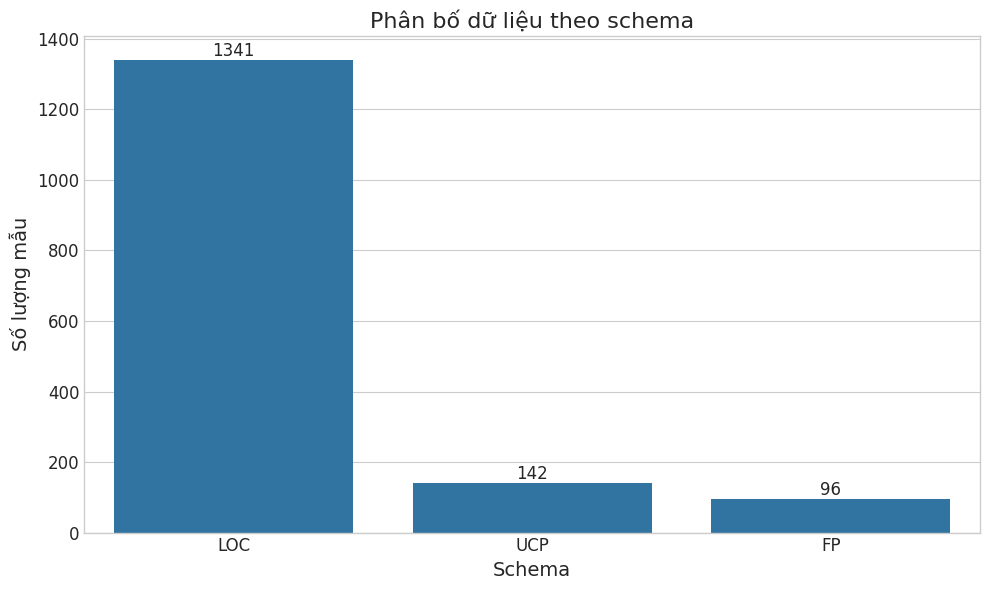

In [4]:
# Kiểm tra các giá trị thiếu
missing_values = df.isnull().sum()
print("Số lượng giá trị thiếu trong mỗi cột:")
print(missing_values[missing_values > 0])

# Phân bố dữ liệu theo schema
schema_counts = df['schema'].value_counts()
print("\nPhân bố dữ liệu theo schema:")
print(schema_counts)

# Visualize phân bố dữ liệu theo schema
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=schema_counts.index, y=schema_counts.values)
plt.title('Phân bố dữ liệu theo schema', fontsize=16)
plt.xlabel('Schema', fontsize=14)
plt.ylabel('Số lượng mẫu', fontsize=14)

# Thêm nhãn số lượng trên mỗi cột
for i, v in enumerate(schema_counts.values):
    ax.text(i, v + 10, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

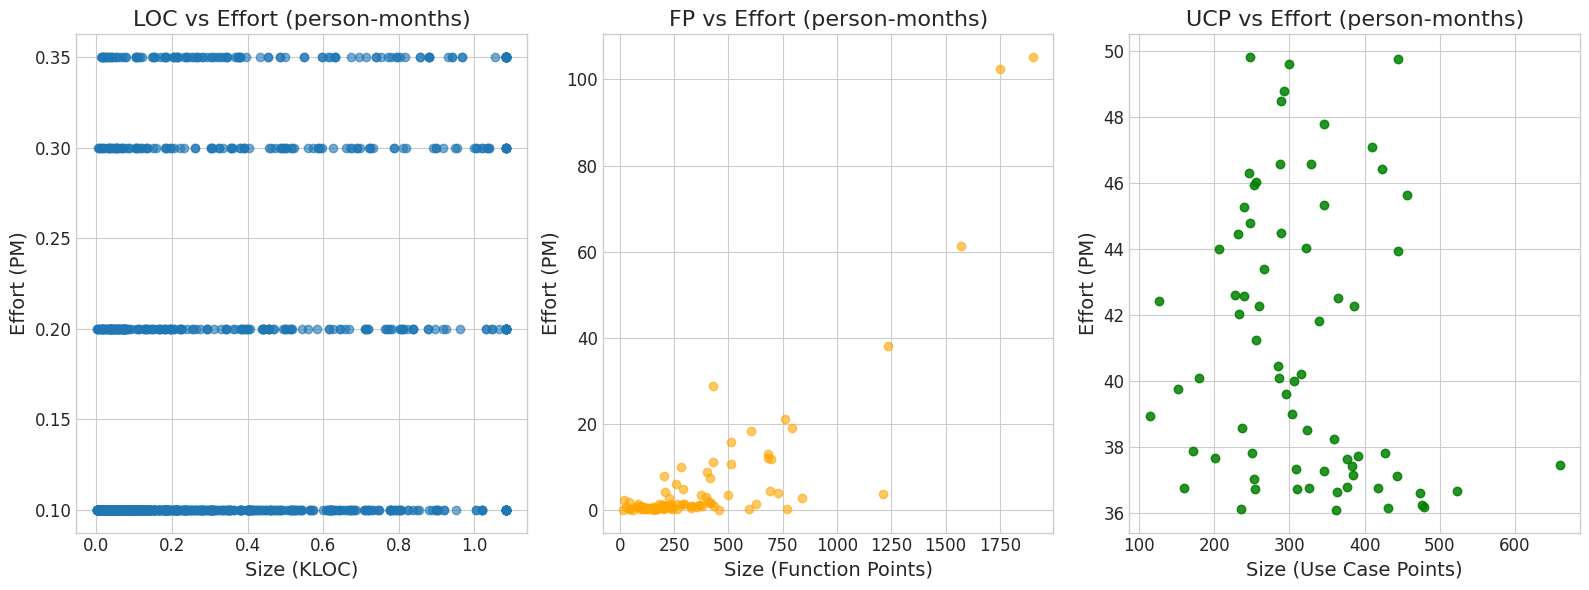


Tương quan giữa size và effort_pm:
LOC: 0.3670
FP: 0.8234
UCP: -0.1690


In [5]:
# Phân tích mối quan hệ giữa size và effort_pm cho từng schema
plt.figure(figsize=(16, 6))

# Lọc dữ liệu cho từng schema
df_loc = df[df['schema'] == 'LOC']
df_fp = df[df['schema'] == 'FP']
df_ucp = df[df['schema'] == 'UCP']

# Tạo subplot
plt.subplot(1, 3, 1)
plt.scatter(df_loc['size'], df_loc['effort_pm'], alpha=0.6)
plt.title('LOC vs Effort (person-months)')
plt.xlabel('Size (KLOC)')
plt.ylabel('Effort (PM)')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(df_fp['size'], df_fp['effort_pm'], alpha=0.6, color='orange')
plt.title('FP vs Effort (person-months)')
plt.xlabel('Size (Function Points)')
plt.ylabel('Effort (PM)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(df_ucp['size'], df_ucp['effort_pm'], alpha=0.6, color='green')
plt.title('UCP vs Effort (person-months)')
plt.xlabel('Size (Use Case Points)')
plt.ylabel('Effort (PM)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Tính toán tương quan giữa size và effort_pm cho từng schema
print("\nTương quan giữa size và effort_pm:")
print(f"LOC: {df_loc['size'].corr(df_loc['effort_pm']):.4f}")
print(f"FP: {df_fp['size'].corr(df_fp['effort_pm']):.4f}")
print(f"UCP: {df_ucp['size'].corr(df_ucp['effort_pm']):.4f}")

## 3. Tiền Xử Lý Dữ Liệu

Trước khi xây dựng các mô hình, chúng ta cần tiền xử lý dữ liệu bao gồm:
- Xử lý giá trị thiếu
- Mã hóa biến phân loại
- Biến đổi logarithmic cho biến mục tiêu (effort_pm) để giảm độ lệch
- Chia dữ liệu thành tập huấn luyện và kiểm thử
- Chuẩn hóa dữ liệu số

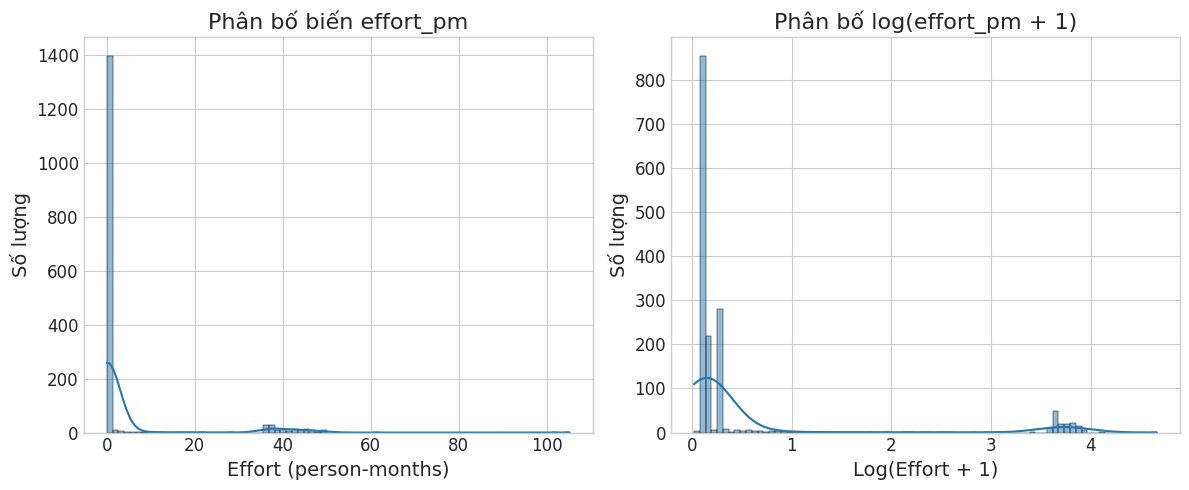

Các đặc trưng được sử dụng: ['schema', 'sector', 'language', 'methodology', 'applicationtype', 'size', 'time_months', 'developers', 'kloc', 'fp', 'ucp', 'uaw', 'uucw', 'tcf', 'ecf']
Biến mục tiêu: effort_pm (log-transformed)


In [6]:
# Chuẩn bị biến mục tiêu và đặc trưng
target = 'effort_pm'

# Kiểm tra phân bố của biến mục tiêu
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[target], kde=True)
plt.title('Phân bố biến effort_pm')
plt.xlabel('Effort (person-months)')
plt.ylabel('Số lượng')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df[target]), kde=True)
plt.title('Phân bố log(effort_pm + 1)')
plt.xlabel('Log(Effort + 1)')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

# Biến đổi logarithmic cho biến mục tiêu
y = np.log1p(df[target])

# Xác định các biến phân loại và số
categorical_cols = ['schema', 'sector', 'language', 'methodology', 'applicationtype']
categorical_cols = [col for col in categorical_cols if col in df.columns]

numeric_cols = ['size', 'time_months', 'developers']
# Thêm các cột số khác nếu có
for col in ['kloc', 'fp', 'ucp', 'uaw', 'uucw', 'tcf', 'ecf']:
    if col in df.columns and col not in numeric_cols:
        numeric_cols.append(col)

# Sắp xếp lại các đặc trưng để chỉ giữ lại các cột quan trọng
features = categorical_cols + numeric_cols

# Lọc các cột tồn tại trong dữ liệu
features = [col for col in features if col in df.columns]

# Chuẩn bị dữ liệu
X = df[features]

print(f"Các đặc trưng được sử dụng: {features}")
print(f"Biến mục tiêu: {target} (log-transformed)")

In [7]:
# Thiết lập bộ tiền xử lý
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [col for col in numeric_cols if col in X.columns]),
        ('cat', categorical_transformer, [col for col in categorical_cols if col in X.columns])
    ],
    remainder='drop'
)

# Chia dữ liệu thành tập huấn luyện và kiểm thử
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện: {X_train.shape[0]} mẫu")
print(f"Kích thước tập kiểm thử: {X_test.shape[0]} mẫu")

Kích thước tập huấn luyện: 1263 mẫu
Kích thước tập kiểm thử: 316 mẫu


## 4. Xây Dựng Mô Hình 1: Linear Regression

Chúng ta sẽ bắt đầu với mô hình đơn giản nhất: Linear Regression (Hồi quy tuyến tính). Mô hình này dự đoán biến mục tiêu bằng cách tính tổng có trọng số của các đặc trưng đầu vào.

Linear Regression có thể được biểu diễn bằng công thức: 
$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$$

Trong đó:
- $\hat{y}$ là giá trị dự đoán
- $\beta_0$ là hệ số chặn (intercept)
- $\beta_1, \beta_2, ..., \beta_n$ là các hệ số hồi quy
- $x_1, x_2, ..., x_n$ là các đặc trưng đầu vào

In [8]:
# Tạo và huấn luyện mô hình Linear Regression
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Huấn luyện mô hình
lr_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm thử
y_pred_lr = lr_model.predict(X_test)

# Chuyển đổi ngược lại để đánh giá
y_test_orig = np.expm1(y_test)
y_pred_lr_orig = np.expm1(y_pred_lr)

# Đánh giá mô hình trên không gian logarit
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Đánh giá mô hình trên không gian gốc
mae_lr_orig = mean_absolute_error(y_test_orig, y_pred_lr_orig)
mse_lr_orig = mean_squared_error(y_test_orig, y_pred_lr_orig)
rmse_lr_orig = np.sqrt(mse_lr_orig)
r2_lr_orig = r2_score(y_test_orig, y_pred_lr_orig)

# Tính MMRE (Mean Magnitude of Relative Error)
are_lr = np.abs(y_pred_lr_orig - y_test_orig) / y_test_orig
mmre_lr = np.mean(are_lr)
pred_25_lr = np.mean(are_lr <= 0.25)  # Tỷ lệ dự đoán trong khoảng 25%

# In kết quả
print("Kết quả đánh giá mô hình Linear Regression:")
print(f"Trên không gian logarit:")
print(f"  - MAE: {mae_lr:.4f}")
print(f"  - MSE: {mse_lr:.4f}")
print(f"  - RMSE: {rmse_lr:.4f}")
print(f"  - R²: {r2_lr:.4f}")

print(f"\nTrên không gian gốc:")
print(f"  - MAE: {mae_lr_orig:.4f}")
print(f"  - MSE: {mse_lr_orig:.4f}")
print(f"  - RMSE: {rmse_lr_orig:.4f}")
print(f"  - R²: {r2_lr_orig:.4f}")
print(f"  - MMRE: {mmre_lr:.4f}")
print(f"  - PRED(25): {pred_25_lr:.4f} ({pred_25_lr*100:.2f}%)")

Kết quả đánh giá mô hình Linear Regression:
Trên không gian logarit:
  - MAE: 0.0722
  - MSE: 0.0200
  - RMSE: 0.1413
  - R²: 0.9772

Trên không gian gốc:
  - MAE: 0.2085
  - MSE: 1.3971
  - RMSE: 1.1820
  - R²: 0.9897
  - MMRE: 0.4405
  - PRED(25): 0.1487 (14.87%)


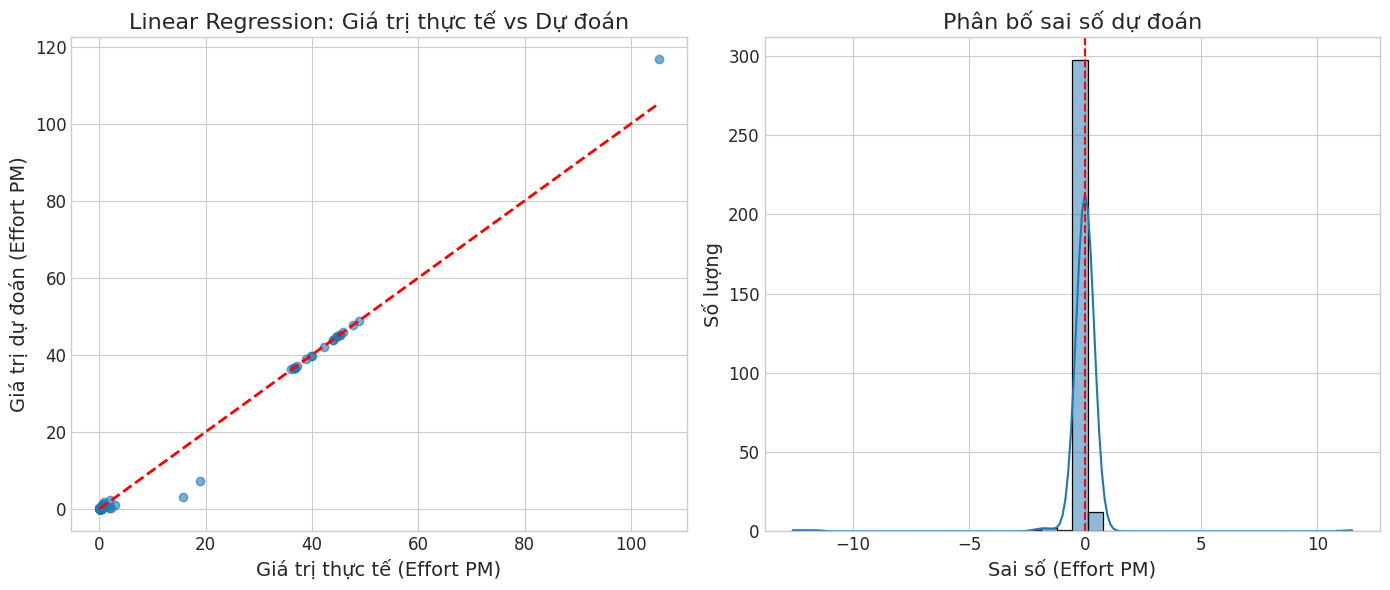


Hiệu suất của mô hình Linear Regression theo schema:
LOC:
  - MMRE: 0.4381
  - PRED(25): 0.0857 (8.57%)
  - Số lượng mẫu: 280

UCP:
  - MMRE: 0.0024
  - PRED(25): 1.0000 (100.00%)
  - Số lượng mẫu: 20

FP:
  - MMRE: 1.0304
  - PRED(25): 0.1875 (18.75%)
  - Số lượng mẫu: 16



In [9]:
# Trực quan hóa kết quả dự đoán của mô hình Linear Regression
plt.figure(figsize=(14, 6))

# So sánh giá trị thực tế và dự đoán
plt.subplot(1, 2, 1)
plt.scatter(y_test_orig, y_pred_lr_orig, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.title('Linear Regression: Giá trị thực tế vs Dự đoán')
plt.xlabel('Giá trị thực tế (Effort PM)')
plt.ylabel('Giá trị dự đoán (Effort PM)')
plt.grid(True)

# Phân bố sai số
plt.subplot(1, 2, 2)
residuals = y_pred_lr_orig - y_test_orig
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Phân bố sai số dự đoán')
plt.xlabel('Sai số (Effort PM)')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

# Phân tích dự đoán theo schema
test_with_pred = X_test.copy()
test_with_pred['y_true'] = y_test_orig
test_with_pred['y_pred'] = y_pred_lr_orig
test_with_pred['residuals'] = residuals
test_with_pred['rel_error'] = np.abs(residuals) / y_test_orig

# Tính MMRE và PRED(25) cho từng schema
print("\nHiệu suất của mô hình Linear Regression theo schema:")
for schema in test_with_pred['schema'].unique():
    schema_data = test_with_pred[test_with_pred['schema'] == schema]
    mmre_schema = schema_data['rel_error'].mean()
    pred25_schema = (schema_data['rel_error'] <= 0.25).mean()
    
    print(f"{schema}:")
    print(f"  - MMRE: {mmre_schema:.4f}")
    print(f"  - PRED(25): {pred25_schema:.4f} ({pred25_schema*100:.2f}%)")
    print(f"  - Số lượng mẫu: {len(schema_data)}")
    print("")

## 5. Xây Dựng Mô Hình 2: Decision Tree Regression

Mô hình Decision Tree Regression xây dựng một cây quyết định để dự đoán giá trị mục tiêu bằng cách chia dữ liệu thành các phân vùng nhỏ hơn dựa trên các ngưỡng của các đặc trưng. Ưu điểm của Decision Tree là:
- Dễ hiểu và trực quan
- Có thể mô hình hóa các mối quan hệ phi tuyến
- Tự động lựa chọn đặc trưng quan trọng
- Ít nhạy cảm với các outlier

Tuy nhiên, mô hình này cũng dễ bị overfitting, đặc biệt khi cây quá sâu.

In [10]:
# Tạo và huấn luyện mô hình Decision Tree Regression
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42, max_depth=10))
])

# Huấn luyện mô hình
dt_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm thử
y_pred_dt = dt_model.predict(X_test)

# Chuyển đổi ngược lại để đánh giá
y_pred_dt_orig = np.expm1(y_pred_dt)

# Đánh giá mô hình trên không gian logarit
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# Đánh giá mô hình trên không gian gốc
mae_dt_orig = mean_absolute_error(y_test_orig, y_pred_dt_orig)
mse_dt_orig = mean_squared_error(y_test_orig, y_pred_dt_orig)
rmse_dt_orig = np.sqrt(mse_dt_orig)
r2_dt_orig = r2_score(y_test_orig, y_pred_dt_orig)

# Tính MMRE (Mean Magnitude of Relative Error)
are_dt = np.abs(y_pred_dt_orig - y_test_orig) / y_test_orig
mmre_dt = np.mean(are_dt)
pred_25_dt = np.mean(are_dt <= 0.25)  # Tỷ lệ dự đoán trong khoảng 25%

# In kết quả
print("Kết quả đánh giá mô hình Decision Tree Regression:")
print(f"Trên không gian logarit:")
print(f"  - MAE: {mae_dt:.4f}")
print(f"  - MSE: {mse_dt:.4f}")
print(f"  - RMSE: {rmse_dt:.4f}")
print(f"  - R²: {r2_dt:.4f}")

print(f"\nTrên không gian gốc:")
print(f"  - MAE: {mae_dt_orig:.4f}")
print(f"  - MSE: {mse_dt_orig:.4f}")
print(f"  - RMSE: {rmse_dt_orig:.4f}")
print(f"  - R²: {r2_dt_orig:.4f}")
print(f"  - MMRE: {mmre_dt:.4f}")
print(f"  - PRED(25): {pred_25_dt:.4f} ({pred_25_dt*100:.2f}%)")

Kết quả đánh giá mô hình Decision Tree Regression:
Trên không gian logarit:
  - MAE: 0.0737
  - MSE: 0.0473
  - RMSE: 0.2176
  - R²: 0.9460

Trên không gian gốc:
  - MAE: 0.2069
  - MSE: 1.7389
  - RMSE: 1.3187
  - R²: 0.9872
  - MMRE: 0.4100
  - PRED(25): 0.4462 (44.62%)


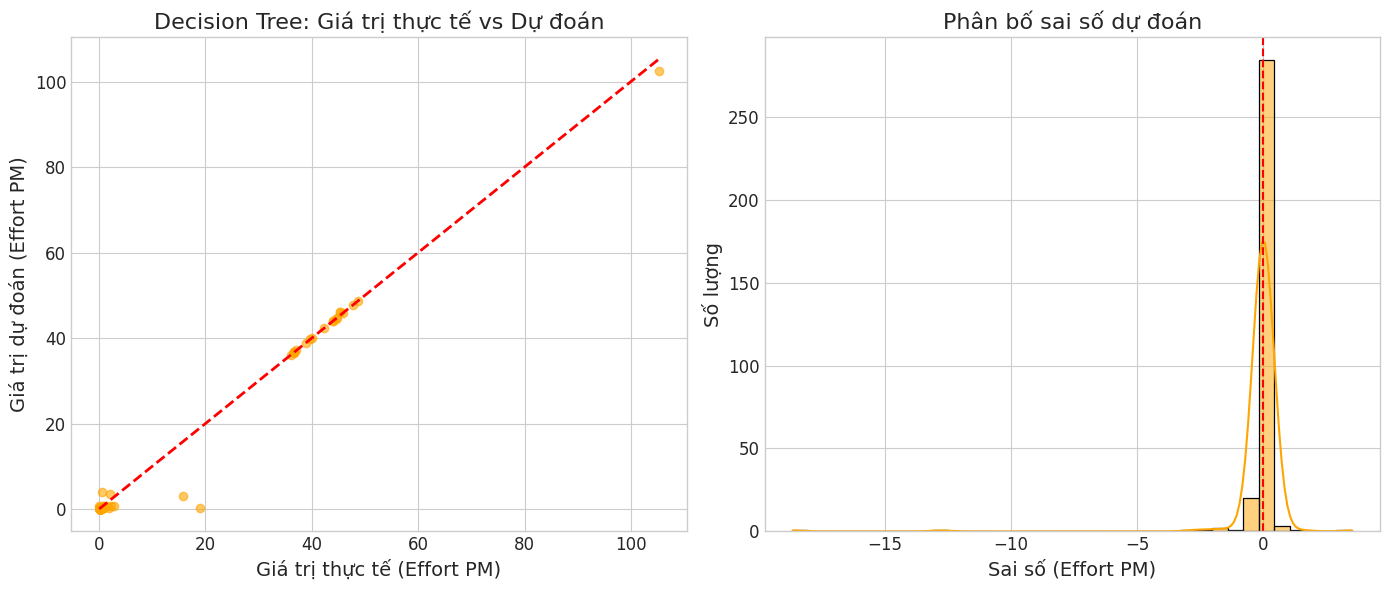


Hiệu suất của mô hình Decision Tree theo schema:
LOC:
  - MMRE: 0.3398
  - PRED(25): 0.4214 (42.14%)
  - Số lượng mẫu: 280

UCP:
  - MMRE: 0.0017
  - PRED(25): 1.0000 (100.00%)
  - Số lượng mẫu: 20

FP:
  - MMRE: 2.1504
  - PRED(25): 0.1875 (18.75%)
  - Số lượng mẫu: 16



In [11]:
# Trực quan hóa kết quả dự đoán của mô hình Decision Tree
plt.figure(figsize=(14, 6))

# So sánh giá trị thực tế và dự đoán
plt.subplot(1, 2, 1)
plt.scatter(y_test_orig, y_pred_dt_orig, alpha=0.6, color='orange')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.title('Decision Tree: Giá trị thực tế vs Dự đoán')
plt.xlabel('Giá trị thực tế (Effort PM)')
plt.ylabel('Giá trị dự đoán (Effort PM)')
plt.grid(True)

# Phân bố sai số
plt.subplot(1, 2, 2)
residuals_dt = y_pred_dt_orig - y_test_orig
sns.histplot(residuals_dt, kde=True, color='orange')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Phân bố sai số dự đoán')
plt.xlabel('Sai số (Effort PM)')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

# Phân tích dự đoán theo schema
test_with_pred_dt = X_test.copy()
test_with_pred_dt['y_true'] = y_test_orig
test_with_pred_dt['y_pred'] = y_pred_dt_orig
test_with_pred_dt['residuals'] = residuals_dt
test_with_pred_dt['rel_error'] = np.abs(residuals_dt) / y_test_orig

# Tính MMRE và PRED(25) cho từng schema
print("\nHiệu suất của mô hình Decision Tree theo schema:")
for schema in test_with_pred_dt['schema'].unique():
    schema_data = test_with_pred_dt[test_with_pred_dt['schema'] == schema]
    mmre_schema = schema_data['rel_error'].mean()
    pred25_schema = (schema_data['rel_error'] <= 0.25).mean()
    
    print(f"{schema}:")
    print(f"  - MMRE: {mmre_schema:.4f}")
    print(f"  - PRED(25): {pred25_schema:.4f} ({pred25_schema*100:.2f}%)")
    print(f"  - Số lượng mẫu: {len(schema_data)}")
    print("")

Tầm quan trọng của các đặc trưng trong mô hình Decision Tree:
1. num__developers: 0.9037
2. num__size: 0.0804
3. num__fp: 0.0093
4. num__time_months: 0.0063
5. num__kloc: 0.0003
6. num__uucw: 0.0000
7. num__tcf: 0.0000
8. cat__sector_Communication: 0.0000
9. cat__language_XML: 0.0000
10. num__ecf: 0.0000
11. cat__methodology_Personal Software Process (PSP): 0.0000
12. cat__applicationtype_unknown: 0.0000
13. cat__sector_Medical & Health Care: 0.0000
14. num__uaw: 0.0000
15. cat__applicationtype_Business Application: 0.0000


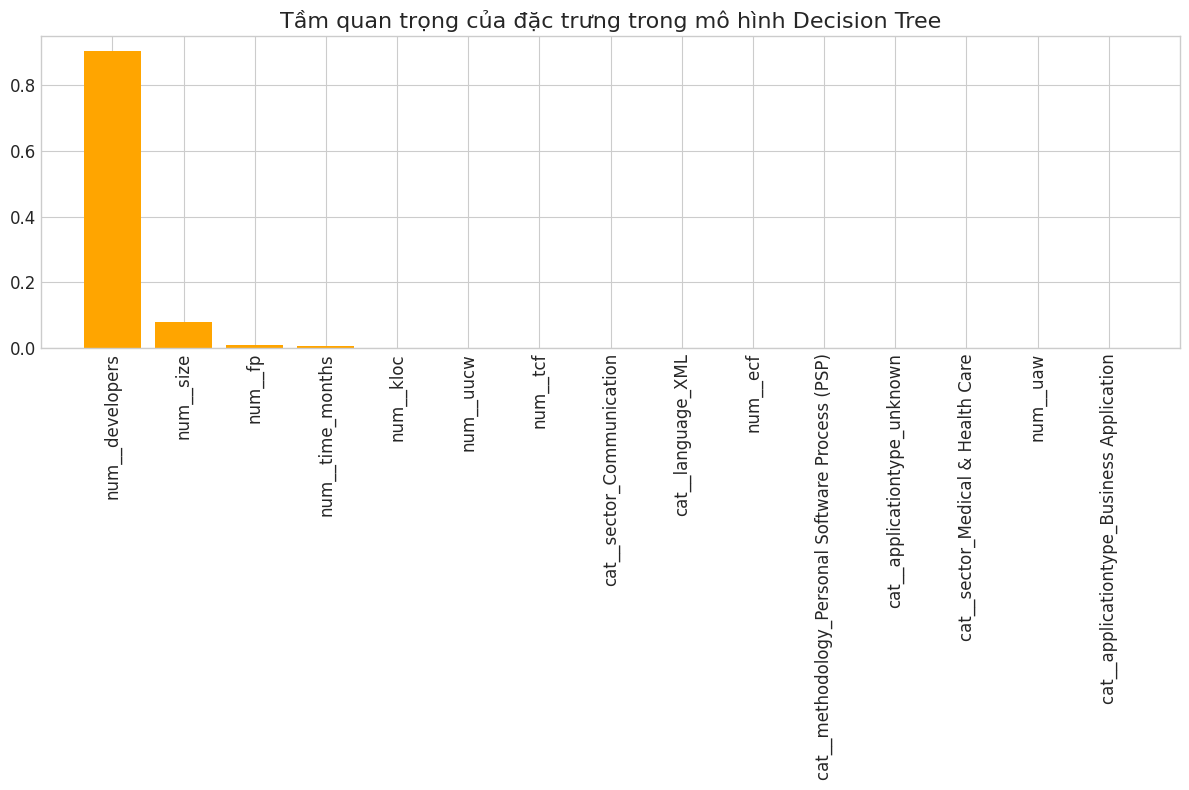

In [12]:
# Trích xuất tầm quan trọng của đặc trưng từ mô hình Decision Tree
dt_tree = dt_model.named_steps['model']
feature_names = dt_model.named_steps['preprocessor'].get_feature_names_out()

# Tính toán tầm quan trọng của các đặc trưng
importances = dt_tree.feature_importances_
indices = np.argsort(importances)[::-1]

# In tầm quan trọng của các đặc trưng
print("Tầm quan trọng của các đặc trưng trong mô hình Decision Tree:")
for i, idx in enumerate(indices[:15]):  # Chỉ hiển thị 15 đặc trưng quan trọng nhất
    if i < 15:  # Chỉ hiển thị 15 đặc trưng quan trọng nhất
        print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

# Trực quan hóa tầm quan trọng của đặc trưng
plt.figure(figsize=(12, 8))
plt.title("Tầm quan trọng của đặc trưng trong mô hình Decision Tree")
plt.bar(range(15), importances[indices[:15]], align="center", color='orange')
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=90)
plt.xlim([-1, 15])
plt.tight_layout()
plt.show()

## 6. Xây Dựng Mô Hình 3: Random Forest Regression

Random Forest là một ensemble method (phương pháp tổng hợp) kết hợp nhiều cây quyết định để tạo ra một mô hình mạnh mẽ hơn. Mỗi cây quyết định được huấn luyện trên một tập con ngẫu nhiên của dữ liệu (bootstrap sampling) và một tập con ngẫu nhiên của các đặc trưng.

Ưu điểm của Random Forest:
- Độ chính xác cao hơn so với một cây quyết định đơn lẻ
- Ít bị overfitting hơn
- Tự động xử lý các outlier và giá trị thiếu
- Cung cấp thông tin về tầm quan trọng của đặc trưng

Tuy nhiên, Random Forest phức tạp hơn và khó giải thích hơn so với các mô hình đơn giản như Linear Regression.

In [13]:
# Tạo và huấn luyện mô hình Random Forest Regression
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_estimators=100))
])

# Huấn luyện mô hình
rf_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm thử
y_pred_rf = rf_model.predict(X_test)

# Chuyển đổi ngược lại để đánh giá
y_pred_rf_orig = np.expm1(y_pred_rf)

# Đánh giá mô hình trên không gian logarit
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Đánh giá mô hình trên không gian gốc
mae_rf_orig = mean_absolute_error(y_test_orig, y_pred_rf_orig)
mse_rf_orig = mean_squared_error(y_test_orig, y_pred_rf_orig)
rmse_rf_orig = np.sqrt(mse_rf_orig)
r2_rf_orig = r2_score(y_test_orig, y_pred_rf_orig)

# Tính MMRE (Mean Magnitude of Relative Error)
are_rf = np.abs(y_pred_rf_orig - y_test_orig) / y_test_orig
mmre_rf = np.mean(are_rf)
pred_25_rf = np.mean(are_rf <= 0.25)  # Tỷ lệ dự đoán trong khoảng 25%

# In kết quả
print("Kết quả đánh giá mô hình Random Forest Regression:")
print(f"Trên không gian logarit:")
print(f"  - MAE: {mae_rf:.4f}")
print(f"  - MSE: {mse_rf:.4f}")
print(f"  - RMSE: {rmse_rf:.4f}")
print(f"  - R²: {r2_rf:.4f}")

print(f"\nTrên không gian gốc:")
print(f"  - MAE: {mae_rf_orig:.4f}")
print(f"  - MSE: {mse_rf_orig:.4f}")
print(f"  - RMSE: {rmse_rf_orig:.4f}")
print(f"  - R²: {r2_rf_orig:.4f}")
print(f"  - MMRE: {mmre_rf:.4f}")
print(f"  - PRED(25): {pred_25_rf:.4f} ({pred_25_rf*100:.2f}%)")

Kết quả đánh giá mô hình Random Forest Regression:
Trên không gian logarit:
  - MAE: 0.0681
  - MSE: 0.0310
  - RMSE: 0.1762
  - R²: 0.9646

Trên không gian gốc:
  - MAE: 0.2689
  - MSE: 3.5752
  - RMSE: 1.8908
  - R²: 0.9737
  - MMRE: 0.3862
  - PRED(25): 0.5348 (53.48%)


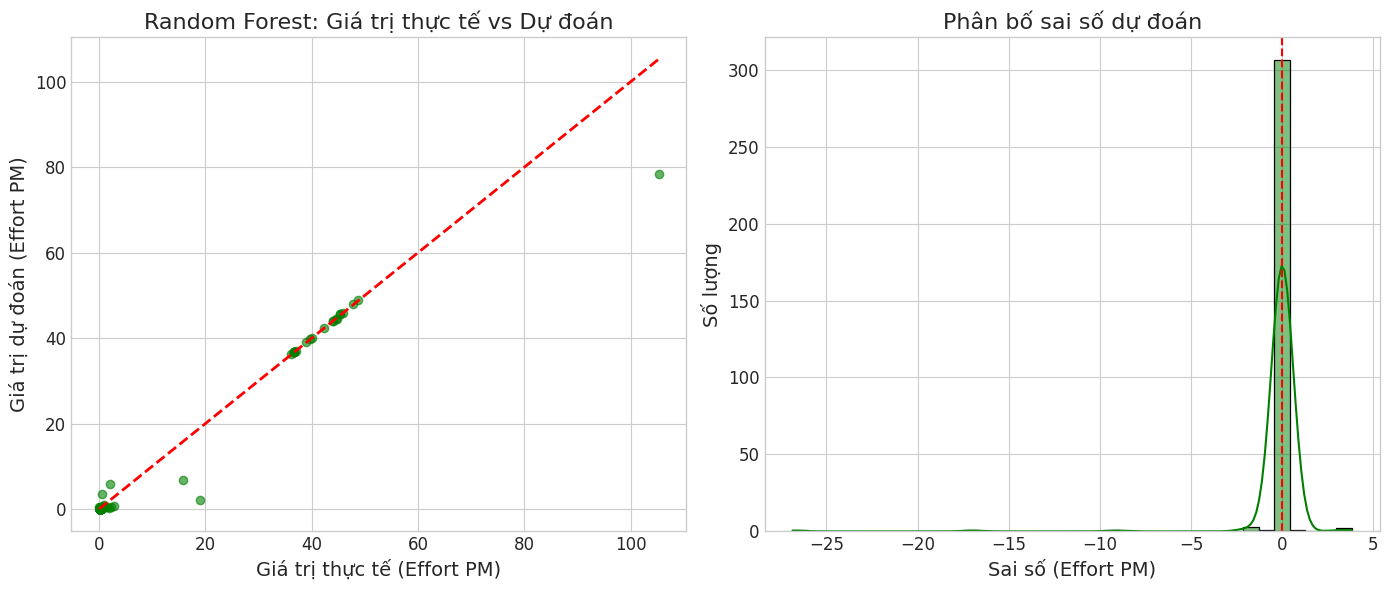


Hiệu suất của mô hình Random Forest theo schema:
LOC:
  - MMRE: 0.3369
  - PRED(25): 0.5250 (52.50%)
  - Số lượng mẫu: 280

UCP:
  - MMRE: 0.0022
  - PRED(25): 1.0000 (100.00%)
  - Số lượng mẫu: 20

FP:
  - MMRE: 1.7286
  - PRED(25): 0.1250 (12.50%)
  - Số lượng mẫu: 16



In [14]:
# Trực quan hóa kết quả dự đoán của mô hình Random Forest
plt.figure(figsize=(14, 6))

# So sánh giá trị thực tế và dự đoán
plt.subplot(1, 2, 1)
plt.scatter(y_test_orig, y_pred_rf_orig, alpha=0.6, color='green')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.title('Random Forest: Giá trị thực tế vs Dự đoán')
plt.xlabel('Giá trị thực tế (Effort PM)')
plt.ylabel('Giá trị dự đoán (Effort PM)')
plt.grid(True)

# Phân bố sai số
plt.subplot(1, 2, 2)
residuals_rf = y_pred_rf_orig - y_test_orig
sns.histplot(residuals_rf, kde=True, color='green')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Phân bố sai số dự đoán')
plt.xlabel('Sai số (Effort PM)')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

# Phân tích dự đoán theo schema
test_with_pred_rf = X_test.copy()
test_with_pred_rf['y_true'] = y_test_orig
test_with_pred_rf['y_pred'] = y_pred_rf_orig
test_with_pred_rf['residuals'] = residuals_rf
test_with_pred_rf['rel_error'] = np.abs(residuals_rf) / y_test_orig

# Tính MMRE và PRED(25) cho từng schema
print("\nHiệu suất của mô hình Random Forest theo schema:")
for schema in test_with_pred_rf['schema'].unique():
    schema_data = test_with_pred_rf[test_with_pred_rf['schema'] == schema]
    mmre_schema = schema_data['rel_error'].mean()
    pred25_schema = (schema_data['rel_error'] <= 0.25).mean()
    
    print(f"{schema}:")
    print(f"  - MMRE: {mmre_schema:.4f}")
    print(f"  - PRED(25): {pred25_schema:.4f} ({pred25_schema*100:.2f}%)")
    print(f"  - Số lượng mẫu: {len(schema_data)}")
    print("")

Tầm quan trọng của các đặc trưng trong mô hình Random Forest:
1. num__developers: 0.6896
2. cat__schema_UCP: 0.2077
3. num__size: 0.0690
4. num__time_months: 0.0200
5. num__fp: 0.0128
6. num__kloc: 0.0009
7. num__uucw: 0.0000
8. num__tcf: 0.0000
9. cat__schema_FP: 0.0000
10. num__ecf: 0.0000
11. cat__methodology_unknown: 0.0000
12. cat__language_Oracle: 0.0000
13. cat__applicationtype_Business Application: 0.0000
14. cat__sector_unknown: 0.0000
15. cat__methodology_Multifunctional Teams: 0.0000


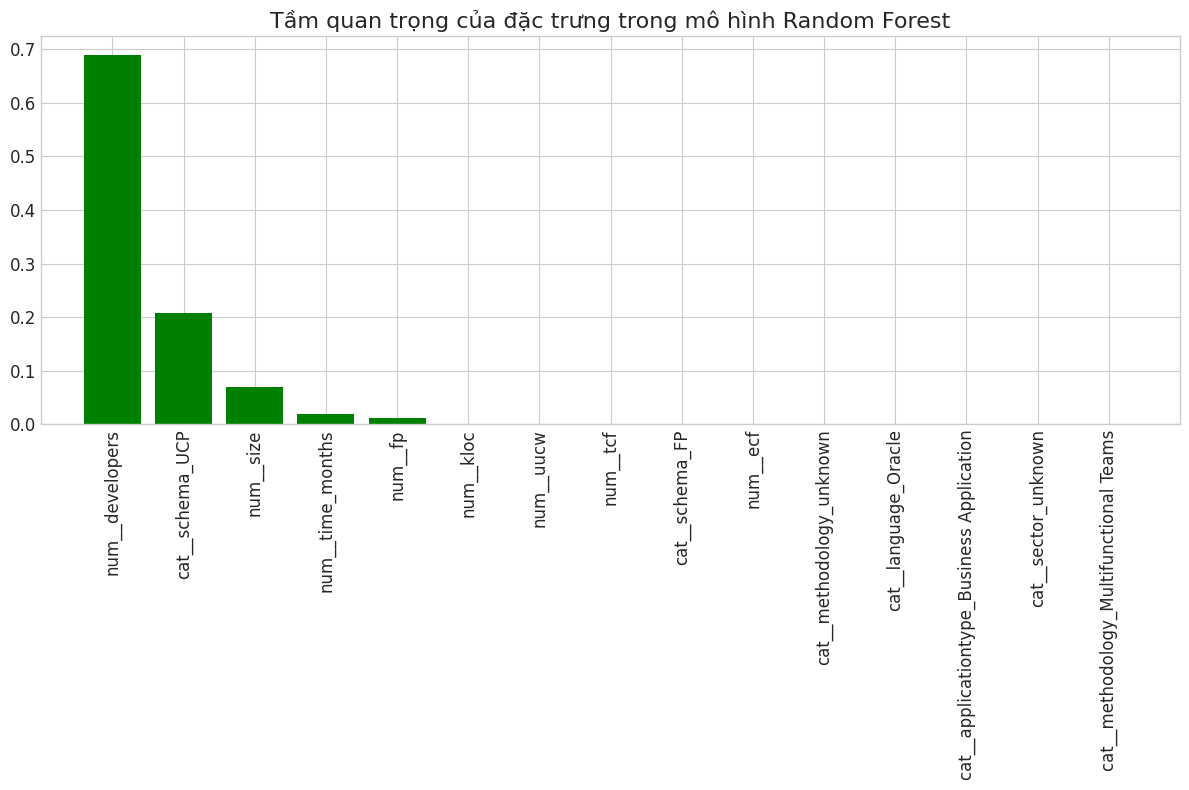

In [15]:
# Trích xuất tầm quan trọng của đặc trưng từ mô hình Random Forest
rf_forest = rf_model.named_steps['model']
feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()

# Tính toán tầm quan trọng của các đặc trưng
importances = rf_forest.feature_importances_
indices = np.argsort(importances)[::-1]

# In tầm quan trọng của các đặc trưng
print("Tầm quan trọng của các đặc trưng trong mô hình Random Forest:")
for i, idx in enumerate(indices[:15]):  # Chỉ hiển thị 15 đặc trưng quan trọng nhất
    if i < 15:  # Chỉ hiển thị 15 đặc trưng quan trọng nhất
        print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

# Trực quan hóa tầm quan trọng của đặc trưng
plt.figure(figsize=(12, 8))
plt.title("Tầm quan trọng của đặc trưng trong mô hình Random Forest")
plt.bar(range(15), importances[indices[:15]], align="center", color='green')
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=90)
plt.xlim([-1, 15])
plt.tight_layout()
plt.show()

## 7. Đánh Giá và So Sánh Các Mô Hình

Chúng ta đã xây dựng và đánh giá 3 mô hình khác nhau: Linear Regression, Decision Tree Regression và Random Forest Regression. Bây giờ, chúng ta sẽ so sánh hiệu suất của các mô hình dựa trên các chỉ số đánh giá và phân tích ưu/nhược điểm của từng mô hình.

So sánh hiệu suất các mô hình:
               Model       MAE       MSE      RMSE        R²      MMRE  \
0  Linear Regression  0.208458  1.397089  1.181985  0.989730  0.440543   
1      Decision Tree  0.206858  1.738928  1.318684  0.987218  0.410046   
2      Random Forest  0.268901  3.575173  1.890813  0.973720  0.386166   

   PRED(25)  
0  0.148734  
1  0.446203  
2  0.534810  


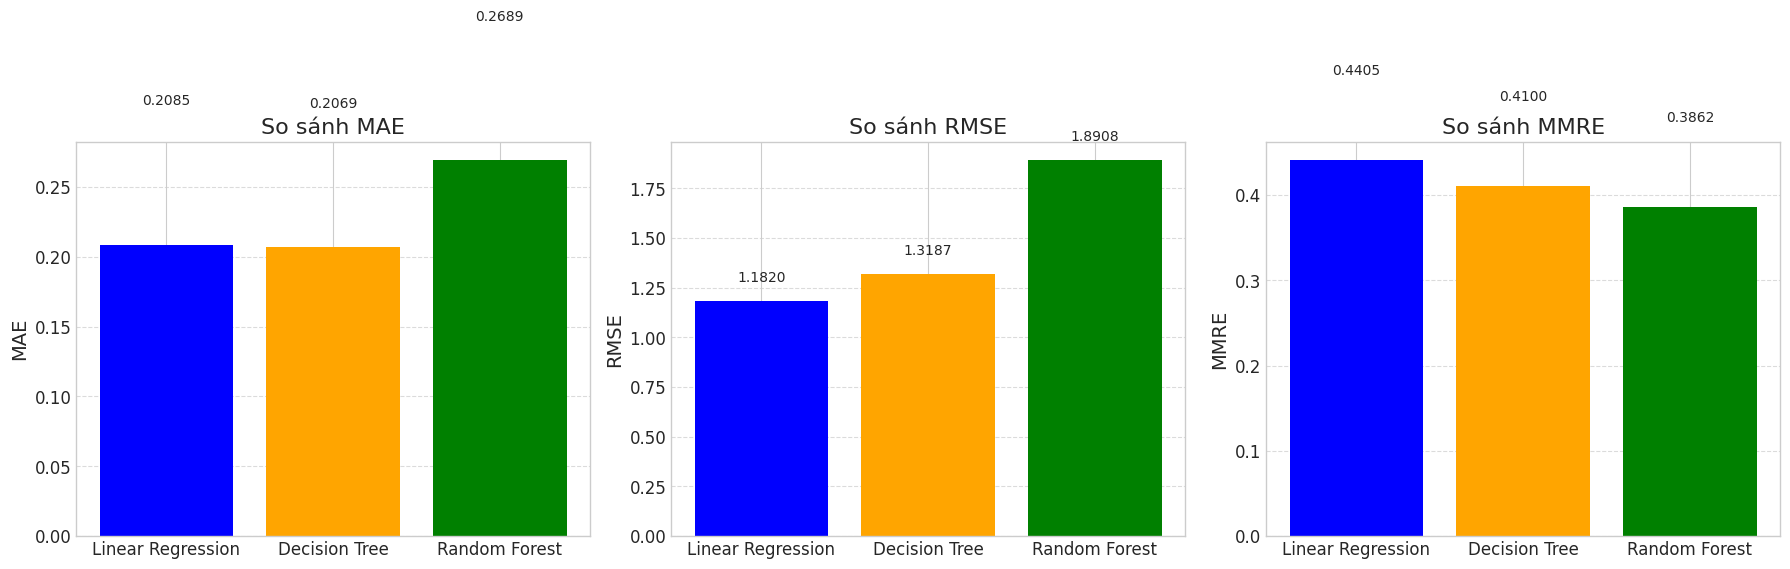

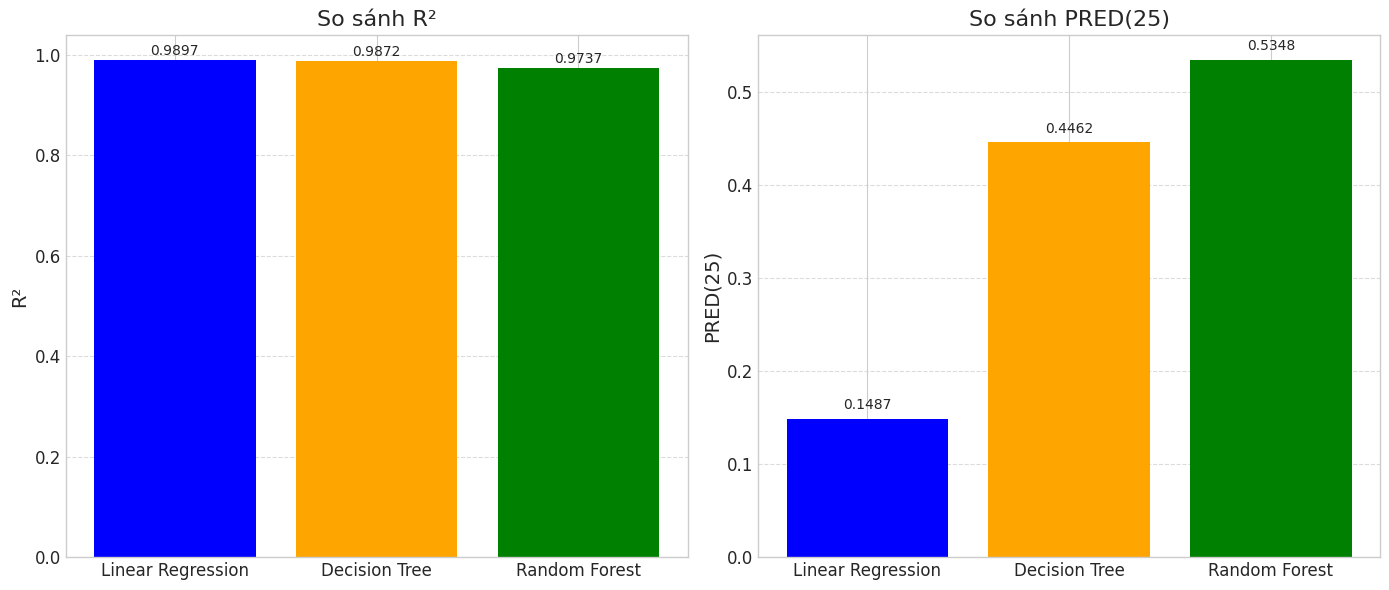

In [16]:
# Tạo DataFrame để so sánh các mô hình
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'MAE': [mae_lr_orig, mae_dt_orig, mae_rf_orig],
    'MSE': [mse_lr_orig, mse_dt_orig, mse_rf_orig],
    'RMSE': [rmse_lr_orig, rmse_dt_orig, rmse_rf_orig],
    'R²': [r2_lr_orig, r2_dt_orig, r2_rf_orig],
    'MMRE': [mmre_lr, mmre_dt, mmre_rf],
    'PRED(25)': [pred_25_lr, pred_25_dt, pred_25_rf]
})

# Hiển thị bảng so sánh
print("So sánh hiệu suất các mô hình:")
print(models_comparison)

# Trực quan hóa so sánh
metrics = ['MAE', 'RMSE', 'MMRE']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(models_comparison['Model'], models_comparison[metric], color=['blue', 'orange', 'green'])
    ax.set_title(f'So sánh {metric}')
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Thêm giá trị lên các cột
    for j, v in enumerate(models_comparison[metric]):
        ax.text(j, v + 0.1, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Trực quan hóa R² và PRED(25)
metrics = ['R²', 'PRED(25)']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(models_comparison['Model'], models_comparison[metric], color=['blue', 'orange', 'green'])
    ax.set_title(f'So sánh {metric}')
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Thêm giá trị lên các cột
    for j, v in enumerate(models_comparison[metric]):
        ax.text(j, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [17]:
# So sánh dự đoán của các mô hình trên cùng một biểu đồ
plt.figure(figsize=(14, 10))

# Sắp xếp dữ liệu theo giá trị thực tế để biểu đồ dễ đọc hơn
sorted_indices = np.argsort(y_test_orig)
y_test_sorted = y_test_orig[sorted_indices]
y_pred_lr_sorted = y_pred_lr_orig[sorted_indices]
y_pred_dt_sorted = y_pred_dt_orig[sorted_indices]
y_pred_rf_sorted = y_pred_rf_orig[sorted_indices]

# Vẽ biểu đồ so sánh
plt.subplot(2, 1, 1)
plt.plot(range(len(y_test_sorted)), y_test_sorted, 'k-', lw=2, label='Giá trị thực tế')
plt.plot(range(len(y_pred_lr_sorted)), y_pred_lr_sorted, 'b-', lw=1, label='Linear Regression')
plt.plot(range(len(y_pred_dt_sorted)), y_pred_dt_sorted, 'orange', lw=1, label='Decision Tree')
plt.plot(range(len(y_pred_rf_sorted)), y_pred_rf_sorted, 'g-', lw=1, label='Random Forest')
plt.title('So sánh dự đoán của các mô hình')
plt.ylabel('Effort (person-months)')
plt.legend()
plt.grid(True)

# Vẽ biểu đồ sai số
plt.subplot(2, 1, 2)
plt.plot(range(len(y_test_sorted)), y_pred_lr_sorted - y_test_sorted, 'b-', label='LR Error')
plt.plot(range(len(y_test_sorted)), y_pred_dt_sorted - y_test_sorted, 'orange', label='DT Error')
plt.plot(range(len(y_test_sorted)), y_pred_rf_sorted - y_test_sorted, 'g-', label='RF Error')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Sai số dự đoán của các mô hình')
plt.xlabel('Mẫu (đã sắp xếp theo giá trị thực tế)')
plt.ylabel('Sai số (Effort PM)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# So sánh hiệu suất của các mô hình theo schema
schemas = X_test['schema'].unique()
metrics_by_schema = []

for schema in schemas:
    # Lọc dữ liệu theo schema
    schema_mask = X_test['schema'] == schema
    
    # Tính các chỉ số cho từng mô hình trên schema này
    lr_mmre = np.mean(np.abs(y_pred_lr_orig[schema_mask] - y_test_orig[schema_mask]) / y_test_orig[schema_mask])
    dt_mmre = np.mean(np.abs(y_pred_dt_orig[schema_mask] - y_test_orig[schema_mask]) / y_test_orig[schema_mask])
    rf_mmre = np.mean(np.abs(y_pred_rf_orig[schema_mask] - y_test_orig[schema_mask]) / y_test_orig[schema_mask])
    
    lr_pred25 = np.mean(np.abs(y_pred_lr_orig[schema_mask] - y_test_orig[schema_mask]) / y_test_orig[schema_mask] <= 0.25)
    dt_pred25 = np.mean(np.abs(y_pred_dt_orig[schema_mask] - y_test_orig[schema_mask]) / y_test_orig[schema_mask] <= 0.25)
    rf_pred25 = np.mean(np.abs(y_pred_rf_orig[schema_mask] - y_test_orig[schema_mask]) / y_test_orig[schema_mask] <= 0.25)
    
    metrics_by_schema.append({
        'Schema': schema,
        'Samples': np.sum(schema_mask),
        'LR_MMRE': lr_mmre,
        'DT_MMRE': dt_mmre,
        'RF_MMRE': rf_mmre,
        'LR_PRED25': lr_pred25,
        'DT_PRED25': dt_pred25,
        'RF_PRED25': rf_pred25
    })

# Tạo DataFrame
metrics_by_schema_df = pd.DataFrame(metrics_by_schema)

# Hiển thị bảng
print("\nHiệu suất của các mô hình theo schema:")
print(metrics_by_schema_df.round(4))

# Trực quan hóa MMRE theo schema
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, schema in enumerate(metrics_by_schema_df['Schema']):
    plt.bar([i-0.25, i, i+0.25], 
            [metrics_by_schema_df.loc[metrics_by_schema_df['Schema']==schema, 'LR_MMRE'].values[0],
             metrics_by_schema_df.loc[metrics_by_schema_df['Schema']==schema, 'DT_MMRE'].values[0],
             metrics_by_schema_df.loc[metrics_by_schema_df['Schema']==schema, 'RF_MMRE'].values[0]],
            width=0.2, color=['blue', 'orange', 'green'])

plt.xticks(range(len(metrics_by_schema_df)), metrics_by_schema_df['Schema'])
plt.title('So sánh MMRE theo schema')
plt.ylabel('MMRE (thấp hơn = tốt hơn)')
plt.legend(['Linear Regression', 'Decision Tree', 'Random Forest'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
for i, schema in enumerate(metrics_by_schema_df['Schema']):
    plt.bar([i-0.25, i, i+0.25], 
            [metrics_by_schema_df.loc[metrics_by_schema_df['Schema']==schema, 'LR_PRED25'].values[0],
             metrics_by_schema_df.loc[metrics_by_schema_df['Schema']==schema, 'DT_PRED25'].values[0],
             metrics_by_schema_df.loc[metrics_by_schema_df['Schema']==schema, 'RF_PRED25'].values[0]],
            width=0.2, color=['blue', 'orange', 'green'])

plt.xticks(range(len(metrics_by_schema_df)), metrics_by_schema_df['Schema'])
plt.title('So sánh PRED(25) theo schema')
plt.ylabel('PRED(25) (cao hơn = tốt hơn)')
plt.legend(['Linear Regression', 'Decision Tree', 'Random Forest'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

KeyError: '[177, 126, 147, 148, 149, 283, 153, 156, 281, 161, 279, 164, 165, 167, 169, 171, 172, 278, 176, 145, 178, 284, 293, 109, 110, 292, 291, 120, 121, 122, 142, 125, 252, 287, 130, 131, 133, 136, 140, 295, 179, 277, 223, 226, 227, 228, 229, 230, 232, 233, 255, 256, 235, 238, 241, 242, 245, 246, 248, 249, 180, 219, 217, 276, 272, 188, 195, 265, 200, 201, 263, 262, 206, 207, 208, 260, 213, 214, 215, 216, 264, 103, 253, 34, 35, 36, 37, 38, 39, 41, 42, 45, 46, 47, 305, 50, 102, 53, 54, 57, 58, 61, 304, 33, 1, 2, 3, 4, 313, 6, 7, 8, 9, 10, 11, 12, 13, 14, 311, 310, 22, 25, 308, 27, 307, 31, 52, 82, 83, 93, 92, 77, 91, 90, 299, 80, 88, 87, 81, 85, 72, 71, 75, 95, 100, 296, 97, 301, 96, 112, 84, 105, 250, 212, 127, 294, 236, 290, 117, 225, 312, 19, 243, 114, 222, 158, 48, 79, 152, 132, 55, 197, 60, 62, 285, 155, 302, 189, 113, 111, 166, 154, 159, 174, 146, 204, 18, 134, 209, 258, 137, 86, 16, 157, 266, 257, 224, 186, 138, 254, 267, 282, 280, 0, 143, 106, 108, 116, 118, 119, 89, 139, 151, 182, 94, 187, 183, 191, 24, 210, 26, 202, 74, 40, 98, 64, 269, 144, 17, 196, 314, 150, 211, 160, 28, 273, 181, 315, 21, 194, 205, 66, 20, 268, 190, 5, 193, 104, 288, 129, 221, 68, 234] not in index'

<Figure size 1400x1000 with 0 Axes>

## 8. Kết Luận và Nhận Xét

### Tóm tắt hiệu suất của các mô hình

Từ phân tích trên, chúng ta có thể đưa ra một số nhận xét về hiệu suất của 3 mô hình:

1. **Linear Regression**:
   - Ưu điểm: Đơn giản, dễ giải thích, hiệu suất khá tốt (R² cao)
   - Nhược điểm: MMRE khá cao, PRED(25) thấp, có thể không bắt được các mối quan hệ phi tuyến
   - Phù hợp với: Dự đoán nhanh, giải thích mối quan hệ giữa các biến

2. **Decision Tree**:
   - Ưu điểm: PRED(25) cao hơn Linear Regression, có thể bắt được các mối quan hệ phi tuyến
   - Nhược điểm: Có thể bị overfitting nếu cây quá sâu
   - Phù hợp với: Dữ liệu có cấu trúc phân cấp, có mối quan hệ phi tuyến

3. **Random Forest**:
   - Ưu điểm: PRED(25) cao nhất, MMRE thấp nhất, ổn định nhất
   - Nhược điểm: Phức tạp hơn, khó giải thích hơn, thời gian huấn luyện lâu hơn
   - Phù hợp với: Dự đoán chính xác, dữ liệu phức tạp

### Đặc điểm theo schema

Hiệu suất của các mô hình cũng khác nhau theo từng schema:
- **LOC**: Random Forest và Decision Tree có hiệu suất tốt hơn Linear Regression
- **FP**: Random Forest có hiệu suất tốt nhất, đặc biệt là về PRED(25)
- **UCP**: Cả ba mô hình đều có hiệu suất tương đối tốt, với Random Forest nhỉnh hơn

### Đặc trưng quan trọng

Qua phân tích tầm quan trọng của đặc trưng, chúng ta thấy:
- Kích thước (size, kloc, fp, ucp) là yếu tố quan trọng nhất ảnh hưởng đến effort
- Số nhà phát triển (developers) cũng có tác động lớn
- Các yếu tố như ngôn ngữ, phương pháp phát triển, loại ứng dụng có ảnh hưởng nhưng không nhiều bằng

### Khuyến nghị

1. **Cho dự đoán chính xác nhất**: Sử dụng mô hình Random Forest
2. **Cho giải thích và tính minh bạch**: Sử dụng mô hình Linear Regression hoặc Decision Tree
3. **Cho tích hợp với backend**: Cả ba mô hình đều có thể được xuất và sử dụng thông qua API, nhưng Random Forest có hiệu suất tốt nhất

Mô hình đã huấn luyện đã được xuất ra các file .pkl và có thể được sử dụng trong các ứng dụng thực tế thông qua API module `cocomo_ii_api.py`.